## Part 1:model 불러오기

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
import openpyxl
from sklearn.cluster import AgglomerativeClustering

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
# 구글드라이브 마운트
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# 학습시킨 모델 가중치를 가져옴 CNN : CA model
model_dir = ['/content/gdrive/My Drive/CA model/p1.h5', '/content/gdrive/My Drive/CA model/p2.h5', '/content/gdrive/My Drive/CA model/p3.h5', '/content/gdrive/My Drive/CA model/p4.h5', '/content/gdrive/My Drive/CA model/p5.h5',
             '/content/gdrive/My Drive/CA model/p6.h5', '/content/gdrive/My Drive/CA model/p7.h5', '/content/gdrive/My Drive/CA model/p8.h5', '/content/gdrive/My Drive/CA model/p9.h5', '/content/gdrive/My Drive/CA model/p10.h5']

## Part2 : 전국 클러스터링

In [5]:
#file 위치 directory 경로
base_dir=r'/content/gdrive/MyDrive/CA model'
#사용할 file 명
excel_file='frog.xlsx'

excel_dir=os.path.join(base_dir, excel_file)

dataF = pd.read_excel(excel_dir, sheet_name ='2006-2017')

dataF=dataF.fillna(0)   #fillna => nan을 찾아서 처리하는 기능이 있다.

dataF=dataF.iloc[:,2:].values

dataF = dataF[dataF[:,1]>34]  #전라도,경상도,충청도
bullfrog = dataF[dataF[:,1]<37] #황소개구리 전체 분포 데이터

Text(0.5, 1.0, 'clusters=25')

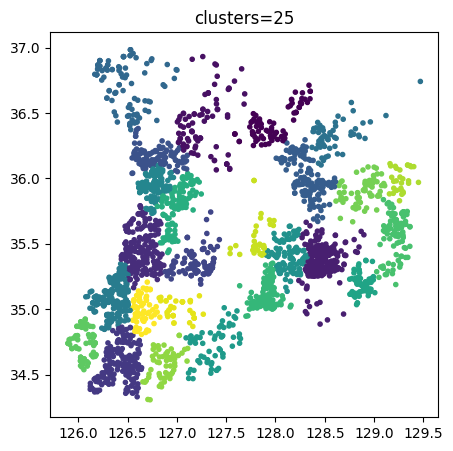

In [6]:
# 군집의 갯수는 25개로 잡음
agg = AgglomerativeClustering(n_clusters = 25)
agg_clusters = agg.fit_predict(bullfrog) #황소개구리 분포데이터를

plt.figure(figsize=(5,5))
plt.scatter(bullfrog[:,0],bullfrog[:,1],c=agg_clusters, marker='.')
plt.title("clusters={}".format(len(np.unique(agg_clusters))))

Text(0.5, 1.0, 'clusters=25')

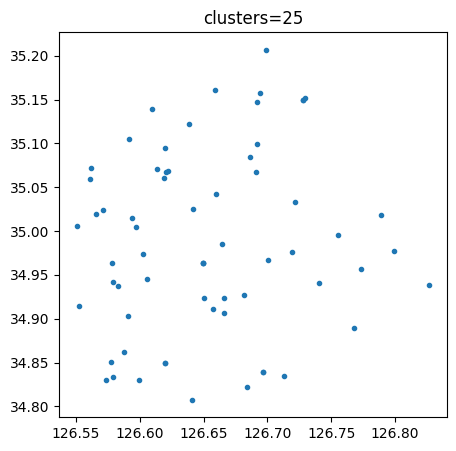

In [7]:
# Cluster 25번의 그림
agg_idx = agg_clusters == 24
bullfrog_cluster = bullfrog[agg_idx]

plt.figure(figsize=(5,5))
plt.scatter(bullfrog_cluster[:,0],bullfrog_cluster[:,1], marker='.')
plt.title("clusters={}".format(len(np.unique(agg_clusters))))

In [8]:
# 20by20으로 분할, 점이 여러개 찍힐 수 있다.
import math
#bullfrog_cluster은 선택한 클러스터 지역, bullfrog_idx는 병합군집 중간과정 Cn
def make_mat(bullfrog_cluster, bullfrog_idx):
  lat_min = min(bullfrog_cluster[:,0]) #위도의 최솟값
  lat_max = max(bullfrog_cluster[:,0]) #위도의 최댓값
  long_min = min(bullfrog_cluster[:,1]) #경도의 최솟값
  long_max = max(bullfrog_cluster[:,1]) #경도의 최댓값
  lat_dis = (lat_max - lat_min)/20 #위도 최댓값 최솟값차를 20으로 나눈값
  long_dis = (long_max - long_min)/20 #경도 최댓값 최솟값차를 20으로 나눈값
  cluster_mat = np.zeros([20,20])
  for x,y in bullfrog_idx: #bullfrog_idx 내의 한점을 선택
    i = math.floor((y - long_min)/long_dis) #그점의 20x20셀의 위치 찾기
    j = math.floor((x - lat_min)/lat_dis)
    if i >= 20:
      i = 19
    if j >= 20:
      j = 19
    cluster_mat[19-i,j] =1 #그점의 위치에 1을 칠함

  return cluster_mat

In [9]:
#클러스터 안에서 병합군집 과정중 idx를 포함하는 행렬 생성
def cluster_mat_list(bullfrog_cluster, idx):
    mat_list = []
    n = len(bullfrog_cluster)
    for i in range(n):
        agg = AgglomerativeClustering(n_clusters = n-i)
        agg_clusters = agg.fit_predict(bullfrog_cluster)
        k = agg_clusters[idx]
        agg_idx = agg_clusters == k
        bullfrog_idx = bullfrog_cluster[agg_idx]

        A = make_mat(bullfrog_cluster,bullfrog_idx)
        mat_list.append(A)

    return mat_list

In [13]:
#클러스터안에서 Cn-1 > Cn 규칙 예측
def pred_bullfrog_cluster_mat(new_mat_list, m, model):
  data_A = []
  for i in range(m-1):
    A_j = np.array([new_mat_list[i],new_mat_list[i+1]])
    data_A.append(A_j)

  data_A = np.transpose(data_A, axes=(0,2,3,1))

  data_A = np.reshape(data_A,(m-1,1,20,20,2))

  pred_a = model.predict(data_A[m-2], verbose=0)
  return pred_a

In [14]:
def pred_cluster( bullfrog, agg_clusters, cluster_num):
  agg_idx = agg_clusters == cluster_num
  bullfrog_cluster = bullfrog[agg_idx]
  n= len(bullfrog_cluster)

  agg = AgglomerativeClustering(n_clusters = n-1)
  agg_cluster = agg.fit_predict(bullfrog_cluster)
  #가장 먼저 합쳐지는 점을 찾기
  for i in range(n):
    for j in range(n):
        if i != j:
            if agg_cluster[i] == agg_cluster[j]:
                idx = i #idx가 이 클러스터 안에서 가장먼저 병합되는점
  #중복되는 부분 삭제
  mat_list = cluster_mat_list(bullfrog_cluster, idx)
  new_mat_list =[mat_list[0]]
  i = 0
  for mat in mat_list:
      if np.any(new_mat_list[i] != mat):
          new_mat_list.append(mat)
          i +=1

  m = len(new_mat_list)
  #10가지의 모델결과로 규칙별 확률의 평균값을계산
  pred_list=np.zeros((1,128))
  for direc in model_dir:
    model = tf.keras.models.load_model(direc)
    pred_a = pred_bullfrog_cluster_mat(new_mat_list, m, model)
    pred_list += pred_a
  pred_list = pred_list/10
  pred_list= np.reshape(pred_list,128)

  return pred_list


In [15]:
pred_list = pred_cluster( bullfrog, agg_clusters, 1)

In [16]:
# 규칙별 가중치
rule_list = np.array([0, 29, 55, 47, 0, 38, 74, 76, 28, 103, 47, 141, 30, 80, 198, 200, 0, 38, 32, 46, 0, 47, 58, 61, 37, 199, 46, 190, 47, 213, 194, 253, 0, 30, 74, 198, 29, 45, 94, 215, 38, 80, 74, 199, 46, 189, 214, 230, 0, 47, 58, 194, 20, 97, 89, 226, 47,
             212, 61, 252, 94, 202, 225, 203, 0, 29, 59, 48, 0, 41, 74, 78, 29, 103, 49, 198, 30, 82, 198, 263, 0, 40, 42, 60, 0, 50, 57, 78, 40, 199, 59, 297, 50, 213, 306, 312, 0, 30, 74, 198, 45, 353, 100, 323, 41, 82, 76, 262, 340, 379, 322, 355,
             0, 50, 57, 306, 54, 375, 118, 395, 50, 213, 77, 311, 365, 397, 395, 398])

In [17]:
c= pred_list*rule_list
d= np.sum(c)
print(round(d/100,2))

2.87


In [18]:
# 클러스터별 결과저장
wb = openpyxl.Workbook()
new_filename = '/content/gdrive/MyDrive/CA model/Agg_result.xlsx'
Sheet = wb.active
for e in range(25):
  subject =[]
  subject.append(e)
  asdasd = pred_cluster( bullfrog, agg_clusters, e)
  c= asdasd*rule_list
  d= np.sum(c)
  subject.append(round(d/100,2))
  Sheet.append(subject)
wb.save(new_filename)

In [22]:
# rule=list(range(0,256,2))

def graph_cluster(bullfrog, agg_clusters, cluster_num):
  pred_list = pred_cluster( bullfrog, agg_clusters, cluster_num)

  new_subject =[]
  new_rule=[]
  for i in range(128):
    e= pred_list[i]
    if e>0.01:
      new_subject.append(e)
      new_rule.append(2*i)

  plt.pie(new_subject, labels=new_rule, autopct='%.1f%%', startangle=90, counterclock=False)
  plt.title("cluster={}".format(cluster_num))
  plt.show()



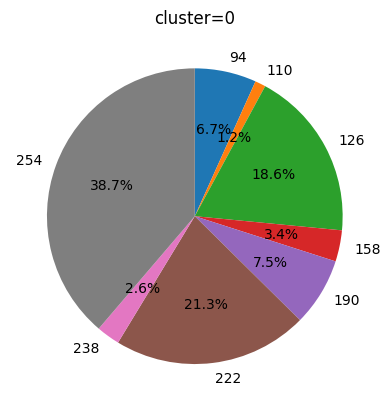

In [23]:
graph_cluster(bullfrog, agg_clusters, 0)